In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
import matplotlib.pyplot as plt

2023-07-31 21:26:56.469938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 21:26:56.471674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 21:26:56.512908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 21:26:56.513539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 21:26:57.290455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
batch_size = 32
img_height = 75
img_width = 75

In [5]:
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (75, 75))
            images.append(img)
            labels.append(label)
    return images, labels


categories = {
    "down": 0,
    "neutral": 1,
    "up": 2,
    "other": 3,
    "activation": 4,
}


X = []
y = []

for category, label in categories.items():
    folder_path = os.path.join("../generator/data/train/", category)
    images, labels = load_images_from_folder(folder_path, label)
    X.extend(images)
    y.extend(labels)

X = np.array(X)
y = np.array(y)

# # Normalize the images to values between 0 and 1
X = X.astype("float32") / 255.0
X

array([[[[0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         ...,
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ],
         [0.        , 1.        , 0.        ]],

        [[0.3137255 , 0.65882355, 0.33333334],
         [0.67058825, 0.5686275 , 0.53333336],
         [0.69411767, 0.5686275 , 0.49019608],
         ...,
         [0.34117648, 0.39215687, 0.42745098],
         [0.30980393, 0.36078432, 0.39607844],
         [0.28235295, 0.32941177, 0.36862746]],

        [[0.32941177, 0.6666667 , 0.35686275],
         [0.59607846, 0.5803922 , 0.5294118 ],
         [0.6509804 , 0.53333336, 0.42745098],
         ...,
         [0.3529412 , 0.40392157, 0.43137255],
         [0.3372549 , 0.38431373, 0.43137255],
         [0.32941177, 0.34117648, 0.38431373]],

        ...,

        [[0.09803922, 0.44705883, 0.11372549],
         [0.11372549, 0.14117648, 0.13725491]

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert labels to one-hot encoding
y_train = utils.to_categorical(y_train, len(categories))
y_test = utils.to_categorical(y_test, len(categories))

# Step 2: Create the deep learning model for gesture detection


def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# Define the input shape and number of classes (gestures)
input_shape = X_train[0].shape
num_classes = len(categories)

# Create the model
model = create_model(input_shape, num_classes)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 128)         0

In [7]:
# Train the model

history = model.fit(
    X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test)
)

# Load and preprocess the test dataset

X_test = []
y_test = []

for category, label in categories.items():
    folder_path = os.path.join("../generator/data/test/", category)
    images, labels = load_images_from_folder(folder_path, label)
    X_test.extend(images)
    y_test.extend(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.astype("float32") / 255.0
y_test = utils.to_categorical(y_test, len(categories))

print()
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/15
47/47 [==============================] - 4s 70ms/step - loss: 1.5359 - accuracy: 0.3117 - val_loss: 1.2174 - val_accuracy: 0.5374
Epoch 2/15
47/47 [==============================] - 3s 66ms/step - loss: 0.9283 - accuracy: 0.6535 - val_loss: 0.8223 - val_accuracy: 0.6738
Epoch 3/15
47/47 [==============================] - 3s 67ms/step - loss: 0.5340 - accuracy: 0.8020 - val_loss: 0.4951 - val_accuracy: 0.8209
Epoch 4/15
47/47 [==============================] - 3s 65ms/step - loss: 0.3174 - accuracy: 0.8950 - val_loss: 0.3721 - val_accuracy: 0.8529
Epoch 5/15
47/47 [==============================] - 3s 66ms/step - loss: 0.1838 - accuracy: 0.9391 - val_loss: 0.2978 - val_accuracy: 0.8904
Epoch 6/15
47/47 [==============================] - 3s 67ms/step - loss: 0.1281 - accuracy: 0.9592 - val_loss: 0.3538 - val_accuracy: 0.8904
Epoch 7/15
47/47 [==============================] - 3s 66ms/step - loss: 0.0845 - accuracy: 0.9719 - val_loss: 0.2291 - val_accuracy: 0.9225
Epoch 8/15
47

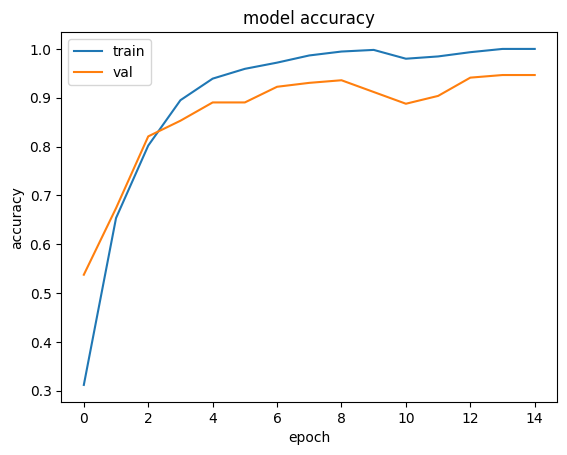

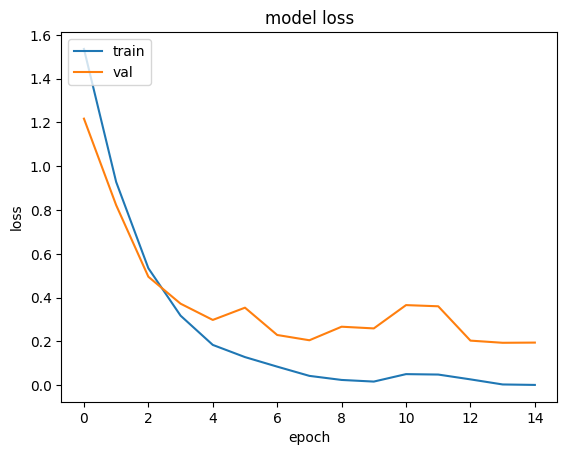

In [8]:
# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [9]:
from tensorflow.keras.models import save_model, load_model

# Save the trained model
model.save("gesture_detection_model.h5")

/home/ansah/Documents/Programming/Projects/gesture-scroll/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
image_path = "../generator/data/test/up/hand_1690818712.8543477_0.png"
img = cv2.imread(image_path)

# Convert BGR to RGB for correct colors
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")  # Hide the axis ticks and labels
plt.show()

img = cv2.resize(img, (75, 75))
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Make predictions on the image using the pre-trained model (assuming 'model' is defined)
predicted_probabilities = model.predict(img)
print(predicted_probabilities)

# Get the index of the second largest probability
second_largest_index = np.argsort(predicted_probabilities[0])[-2]

# Get the label from the categories dictionary (assuming 'categories' is defined)
gesture_label = None
for label, value in categories.items():
    if value == second_largest_index:
        gesture_label = label
        break

print("Predicted gesture label with the second largest probability:", gesture_label)

In [ ]:
# # Load the saved model
# loaded_model = load_model("gesture_detection_model.h5")